In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
#lendo o dataset
df = pd.read_csv('data/stats.csv')

#define a ordem do dataset como sendo crescente de acordo com o ano
df = df.sort_values(by='Year')

#reseta os índices do dataset e deleta a coluna de índices antigos
df = df.reset_index(drop=True)

#deleta a segunda coluna
df = df.drop(df.columns[0], axis=1)

#deleta a coluna "Season", porque todas são iguais
df = df.drop('Season', axis=1)

#traduzindo os nomes das medalhas para inteiros
df['Medal'] = df['Medal'].replace({'Gold': 1, 'Silver': 2, 'Bronze': 3, np.nan: np.nan})

#criando uma coluna de índice de país (com base na coluna "NOC")
df['NNOC'] = pd.Categorical(df['NOC'])
df['NNOC'] = df['NNOC'].cat.codes

df.head()

/tmp/ipykernel_23356/407779106.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Medal'] = df['Medal'].replace({'Gold': 1, 'Silver': 2, 'Bronze': 3, np.nan: np.nan})


,Name,Sex,Age,Team,NOC,Games,Year,City,Sport,Event,Medal,NNOC
0,Paul Neumann (-Newman),M,20.0,Austria,AUT,1896 Summer,1896,Athina,Swimming,Swimming Men's 500 metres Freestyle,1.0,13
1,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Great Britain/Germany,GER,1896 Summer,1896,Athina,Tennis,Tennis Men's Doubles,1.0,80
2,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Germany,GER,1896 Summer,1896,Athina,Athletics,Athletics Men's 100 metres,NaN,80
3,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Germany,GER,1896 Summer,1896,Athina,Athletics,Athletics Men's 800 metres,NaN,80
4,Efstathios Khorafas,M,NaN,Greece,GRE,1896 Summer,1896,Athina,Swimming,Swimming Men's 100 metres Freestyle,NaN,82


In [69]:
#mostrando uma tabela com a tradução de o que significa cada NNOC com base no NOC
NOC = df[['NOC', 'NNOC']]
NOC = NOC.drop_duplicates()
NOC = NOC.sort_values(by='NNOC')
NOC = NOC.reset_index(drop=True)
NOC.head()

,NOC,NNOC
0,AFG,0
1,AHO,1
2,ALB,2
3,ALG,3
4,AND,4


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237673 entries, 0 to 237672
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Name    237673 non-null  object 
 1   Sex     237673 non-null  object 
 2   Age     228484 non-null  float64
 3   Team    237673 non-null  object 
 4   NOC     237673 non-null  object 
 5   Games   237673 non-null  object 
 6   Year    237673 non-null  int64  
 7   City    237673 non-null  object 
 8   Sport   237673 non-null  object 
 9   Event   237673 non-null  object 
 10  Medal   36537 non-null   float64
 11  NNOC    237673 non-null  int16  
dtypes: float64(2), int16(1), int64(1), object(8)
memory usage: 20.4+ MB


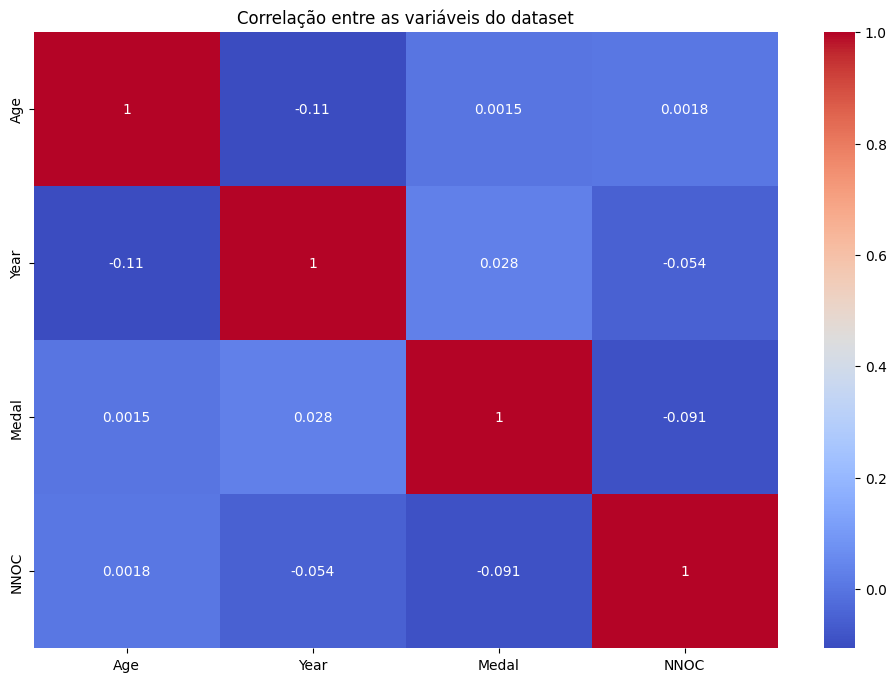

In [71]:
#plotando o gráfico de correlação

#filtrando o dataset apenas para valores numéricos
dfn = df.select_dtypes(include=[np.number])

corr = dfn.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlação entre as variáveis do dataset')
plt.show()

In [159]:
import ipywidgets as widgets
from IPython.display import display

#criando um slider para selecionar o intervalo de anos
year_slider = widgets.IntRangeSlider(
    value=[1896, 2020],
    min=1896,
    max=2020,
    step=4,
    description='Intervalo de ano:',
    continuous_update=False
)

#criando um dropdown para selecionar a quantidade de países a serem mostrados
top_countries_dropdown = widgets.Dropdown(
    options=[5, 10, 15],
    value=10,
    description='Número de países:',
    disabled=False,
)

#criando a função que irá atualizar o gráfico de acordo com os valores selecionados
def update_plot(year_interval, top_countries):
    filtered_df1 = df[(df['Year'] >= year_interval[0]) & (df['Year'] <= year_interval[1])]
    filtered_df = filtered_df1.groupby('Team')['Medal'].count().nlargest(top_countries)
    filtered_df = pd.DataFrame({'Team': filtered_df.index, 'Medal': filtered_df.values})

    #adicionando no dataframe quantas das medalhas são de ouro, de prata e de bronze
    gold = []
    silver = []
    bronze = []
    for team in filtered_df['Team']:
        gold.append(len(filtered_df1[(filtered_df1['Team'] == team) & (filtered_df1['Medal'] == 1)]))
        silver.append(len(filtered_df1[(filtered_df1['Team'] == team) & (filtered_df1['Medal'] == 2)]))
        bronze.append(len(filtered_df1[(filtered_df1['Team'] == team) & (filtered_df1['Medal'] == 3)]))
    filtered_df['Gold'] = gold
    filtered_df['Silver'] = silver
    filtered_df['Bronze'] = bronze

    #define os dados que serão plotados
    medal_counts = filtered_df[['Gold', 'Silver', 'Bronze']]
    countries = filtered_df['Team']

    #largura da barra
    bar_w = 0.7

    #posição da barra
    r = np.arange(len(countries))

    #criando a ordem de plotagem
    plt.figure(figsize=(14, 8))
    plt.barh(r, medal_counts['Bronze'], color='brown', height=bar_w, edgecolor='black', label='Bronze')
    plt.barh(r, medal_counts['Silver'], left=medal_counts['Bronze'], color='silver', height=bar_w, edgecolor='black', label='Silver')
    plt.barh(r, medal_counts['Gold'], left=medal_counts['Bronze'] + medal_counts['Silver'], color='gold', height=bar_w, edgecolor='black', label='Gold')

    #invertendo o eixo y (maior pro menor)
    plt.gca().invert_yaxis()

    #labels e título
    plt.xlabel('Número de Medalhas')
    plt.ylabel('Países')
    plt.yticks(r, countries)
    plt.title('Top ' + str(top_countries) + ' países com mais medalhas entre ' + str(year_interval[0]) + ' e ' + str(year_interval[1]))

    #definindo as coordenadas da tabela
    table_coords = [0.75, 0.3, 0.2, 0.4]

    #criando uma tabela
    table_data = [['País', 'Medalhas']] + [[country, medal_counts.loc[i].sum()] for i, country in enumerate(countries)]
    table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center', bbox=table_coords)

    #formata a tabela
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)

    #plotando
    plt.legend(['Bronze', 'Prata', 'Ouro'])
    plt.show()

#criando o output
output = widgets.interactive_output(update_plot, {'year_interval': year_slider, 'top_countries': top_countries_dropdown})

#mostrando os widgets
display(year_slider, top_countries_dropdown, output)

IntRangeSlider(value=(1896, 2020), continuous_update=False, description='Intervalo de ano:', max=2020, min=189…

Dropdown(description='Número de países:', index=1, options=(5, 10, 15), value=10)

Output()